# KovaaK's csv EDA

In [ ]:
##installs that are required
#!pip install pandas numpy matplotlib seaborn scikit-learn torch torchvision torchaudio xgboost lightgbm

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached xgboost-3.1.2-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.20.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision
import torchaudio
import xgboost as xgb
import lightgbm as lgb

# Import my Kovaak's data loader
from kovaaks_loader import load_all_kovaaks_data

In [3]:
import os
print(os.getcwd())
csv_dir = "./stats"

# dataframes = {}
# for filename in os.listdir(csv_dir):
#     if filename.endswith(".csv"):  # Only process .csv files
#         df = pd.read_csv(os.path.join(csv_dir, filename))
#         dataframes[filename] = df  # Store the DataFrame in a dictionary


/Users/aidansmith/Library/CloudStorage/OneDrive-Personal/DocumentsGrad/Projects/AimTrainerCompanion/KovaaKs-Data-Analysis-Companion


Maybe these should be loaded:

Dict{Dict{df}}

where that is:

Task-name{session{df}}

# Notes:

Seemingly every csv (only tested challenge files here) has three sections:

n-length table
 - every "kill" (tracking tasks usually have none) is a row

gun information
 - most columns don't usually get populated


In [20]:
# Load all Kovaak's data using the shared module
main_data, weapon_data, stats_data = load_all_kovaaks_data(csv_dir)



Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Processed 130 files...
Processed 140 files...
Processed 150 files...
Processed 160 files...
Processed 170 files...
Processed 180 files...
Processed 190 files...
Processed 200 files...
Processed 210 files...
Processed 220 files...
Processed 230 files...
Processed 240 files...
Processed 250 files...
Processed 260 files...
Processed 270 files...
Processed 280 files...
Processed 290 files...
Processed 300 files...
Processed 310 files...
Processed 320 files...
Processed 330 files...
Processed 340 files...

Total files processed: 343
Unique tasks: 102


In [21]:
if len(main_data) > 0:
    print("Sample tasks loaded:")
    for i, task_name in enumerate(list(main_data.keys())[:5]):
        print(f"  {i+1}. {task_name}")
        dates = list(main_data[task_name].keys())
        if dates:
            print(f"     Sessions: {len(dates)}")
            # Show example of main data
            example_date = dates[0]
            main_df = main_data[task_name][example_date]
            print(f"     Main data shape: {main_df.shape}")
            # Show example of stats
            stats = stats_data[task_name][example_date]
            if stats:
                print(f"     Sample stats: Kills={stats.get('Kills', 'N/A')}, Score={stats.get('Score', 'N/A')}")
            print()


Sample tasks loaded:
  1. HighGroundTrack - THE FINALS
     Sessions: 12
     Main data shape: (0, 13)
     Sample stats: Kills=20, Score=1840.0

  2. VT Wide Angle Tracking Entry
     Sessions: 1
     Main data shape: (1, 13)
     Sample stats: Kills=0, Score=2744.0

  3. tamTargetSwitch Smooth
     Sessions: 1
     Main data shape: (0, 13)
     Sample stats: Kills=11, Score=11.0

  4. Smoothsphere Initiate
     Sessions: 1
     Main data shape: (1, 13)
     Sample stats: Kills=0, Score=6315.0

  5. Centering II 180 Entry
     Sessions: 3
     Main data shape: (1, 13)
     Sample stats: Kills=0, Score=10098.0



In [ ]:
from datetime import datetime

# Flatten stats_data into a single df
rows = []
for task, sessions in stats_data.items():
    for date_str, stats in sessions.items():
        row = {"task": task, "session_time_str": date_str}
        # Parse datetime if possible
        try:
            row["session_time"] = datetime.strptime(date_str, "%Y.%m.%d-%H.%M.%S")
        except Exception:
            row["session_time"] = None
        # Normalize keys (strip trailing commas) and add stats
        for k, v in stats.items():
            key_clean = k.rstrip(',').strip()
            # Also clean values that might still have commas (defensive)
            if isinstance(v, str):
                v = v.strip().lstrip(',').rstrip(',').strip()
                # Try to convert cleaned string to number
                if v:
                    try:
                        if '.' in v:
                            v = float(v)
                        else:
                            v = int(v)
                    except ValueError:
                        pass  # Keep as string
            row[key_clean] = v
        rows.append(row)

stats_df = pd.DataFrame(rows)

print("stats_df shape:", stats_df.shape)
print("Columns:", sorted(stats_df.columns.tolist())[:20], "...")

# Count sessions per task
session_counts = (
    stats_df.groupby("task")["session_time_str"]
    .nunique()
    .sort_values(ascending=False)
)

print("\nTop 15 tasks by number of sessions:")
print(session_counts.head(15))

# Choose a threshold for \"high-session\" tasks (you can tweak this)
high_session_threshold = 10
high_session_tasks = session_counts[session_counts >= high_session_threshold].index.tolist()
print(f"\nHigh-session tasks (>= {high_session_threshold} sessions): {len(high_session_tasks)}")
print(high_session_tasks[:20])


stats_df shape: (343, 45)
Columns: ['Avg FPS', 'Avg TTK', 'Avg Target Scale', 'Avg Time Dilation', 'Challenge Start', 'Crosshair', 'Crosshair Color', 'Crosshair Scale', 'DPI', 'Damage Done', 'Damage Taken', 'Deaths', 'Directed', 'Directs', 'Distance Traveled', 'FOV', 'FOVScale', 'Fight Time', 'Game Version', 'Hash'] ...

Top 15 tasks by number of sessions:
task
VariousStatic - THE FINALS      21
DistanceTrack - THE FINALS      19
VT ww5t Novice S5               16
HighGroundTrack - THE FINALS    12
VT Pasu Novice S5               12
VT Raw Control Novice S5        11
VT 1w4ts Novice S5              11
ControlSwitch - THE FINALS      11
VT Popcorn Novice S5            10
UnderTrack - THE FINALS          9
VT Ground Novice S5              8
PadTrack - THE FINALS            7
SVGS - THE FINALS                7
VT Controlsphere Novice S5       7
VT EddieTS Novice S5             7
Name: session_time_str, dtype: int64

High-session tasks (>= 10 sessions): 9
['VariousStatic - THE FINALS', 'Di

Tasks to plot: ['VariousStatic - THE FINALS', 'DistanceTrack - THE FINALS', 'VT ww5t Novice S5', 'HighGroundTrack - THE FINALS', 'VT Pasu Novice S5', 'VT Raw Control Novice S5']
plot_df columns: ['Avg FPS', 'Avg TTK', 'Avg Target Scale', 'Avg Time Dilation', 'Challenge Start', 'Crosshair', 'Crosshair Color', 'Crosshair Scale', 'DPI', 'Damage Done', 'Damage Taken', 'Deaths', 'Directed', 'Directs', 'Distance Traveled', 'FOV', 'FOVScale', 'Fight Time', 'Game Version', 'Hash', 'Hide Gun', 'Hit Count', 'Horiz Sens', 'Input Lag', 'Kills'] ...
Score sample values: [1840.0, 1920.0, 2071.0, 2204.0, 1812.0]
Kills sample values: [20, 20, 20, 19, 19]
Non-null Score count: 91
Non-null Kills count: 91


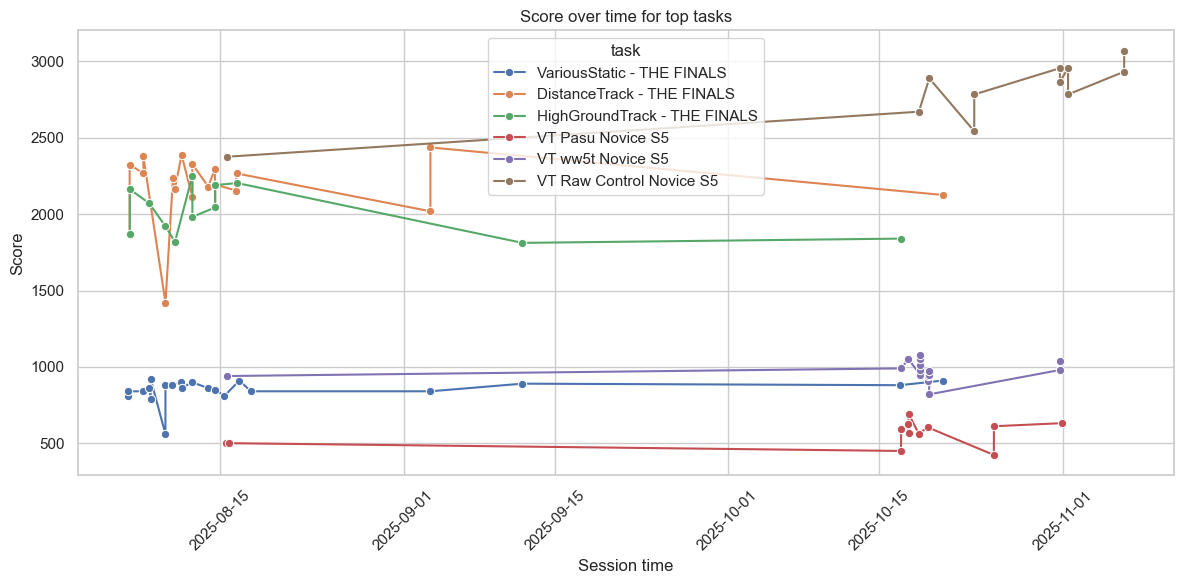

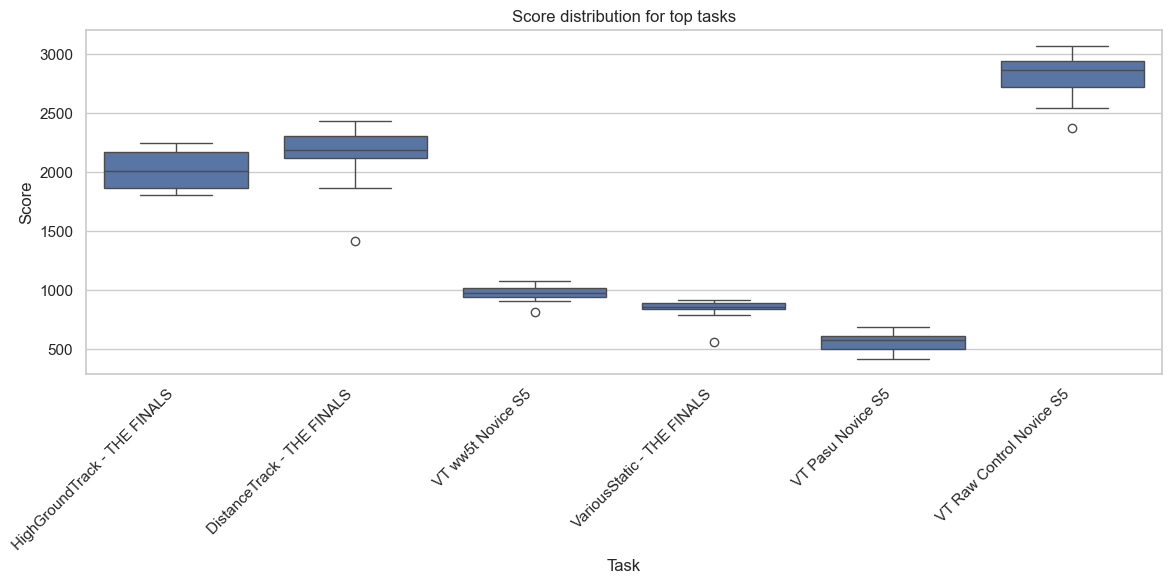

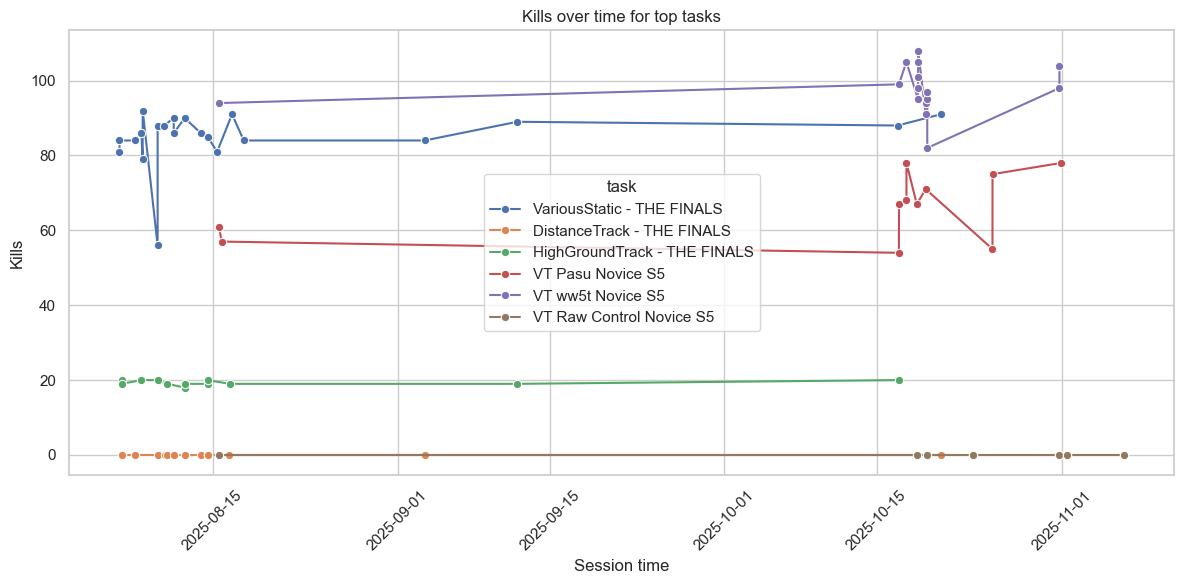

In [ ]:
# Visualizations for high-session tasks

# find non deprecated way to set style
#sns.set(style="whitegrid")

# If you want to focus on just the highest-session tasks, you can limit here
max_tasks_to_plot = 6
if 'session_counts' in globals():
    tasks_to_plot = session_counts.head(max_tasks_to_plot).index.tolist()
else:
    tasks_to_plot = list(stats_df['task'].value_counts().head(max_tasks_to_plot).index)

plot_df = stats_df[stats_df['task'].isin(tasks_to_plot)].copy()

print("Tasks to plot:", tasks_to_plot)
print("plot_df columns:", sorted(plot_df.columns.tolist())[:25], "...")
if "Score" in plot_df.columns:
    print("Score sample values:", plot_df["Score"].head().tolist())
if "Kills" in plot_df.columns:
    print("Kills sample values:", plot_df["Kills"].head().tolist())

# Ensure we have numeric Score and Kills columns if present
for col in ["Score", "Kills"]:
    if col in plot_df.columns:
        plot_df[col] = pd.to_numeric(plot_df[col], errors="coerce")

print("Non-null Score count:", int(plot_df["Score"].notna().sum()) if "Score" in plot_df.columns else "no Score col")
print("Non-null Kills count:", int(plot_df["Kills"].notna().sum()) if "Kills" in plot_df.columns else "no Kills col")

# Score over time for top tasks
if "Score" in plot_df.columns and plot_df["Score"].notna().any():
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=plot_df.sort_values("session_time"),
        x="session_time",
        y="Score",
        hue="task",
        marker="o"
    )
    plt.title("Score over time for top tasks")
    plt.xlabel("Session time")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# boxplot of scores for top tasks
if "Score" in plot_df.columns and plot_df["Score"].notna().any():
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=plot_df,
        x="task",
        y="Score"
    )
    plt.title("Score distribution for top tasks")
    plt.xlabel("Task")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Kills over time, if present
#  should probably further polish a system to separate kill-focused events from other events
#  even still there will be some tasks which report kills but are not kill focused, I think high ground track is an example
if "Kills" in plot_df.columns and plot_df["Kills"].notna().any():
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=plot_df.sort_values("session_time"),
        x="session_time",
        y="Kills",
        hue="task",
        marker="o"
    )
    plt.title("Kills over time for top tasks")
    plt.xlabel("Session time")
    plt.ylabel("Kills")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Due to minor inconsistencies between tasks, these checking if statements are and will continue to be very important